## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

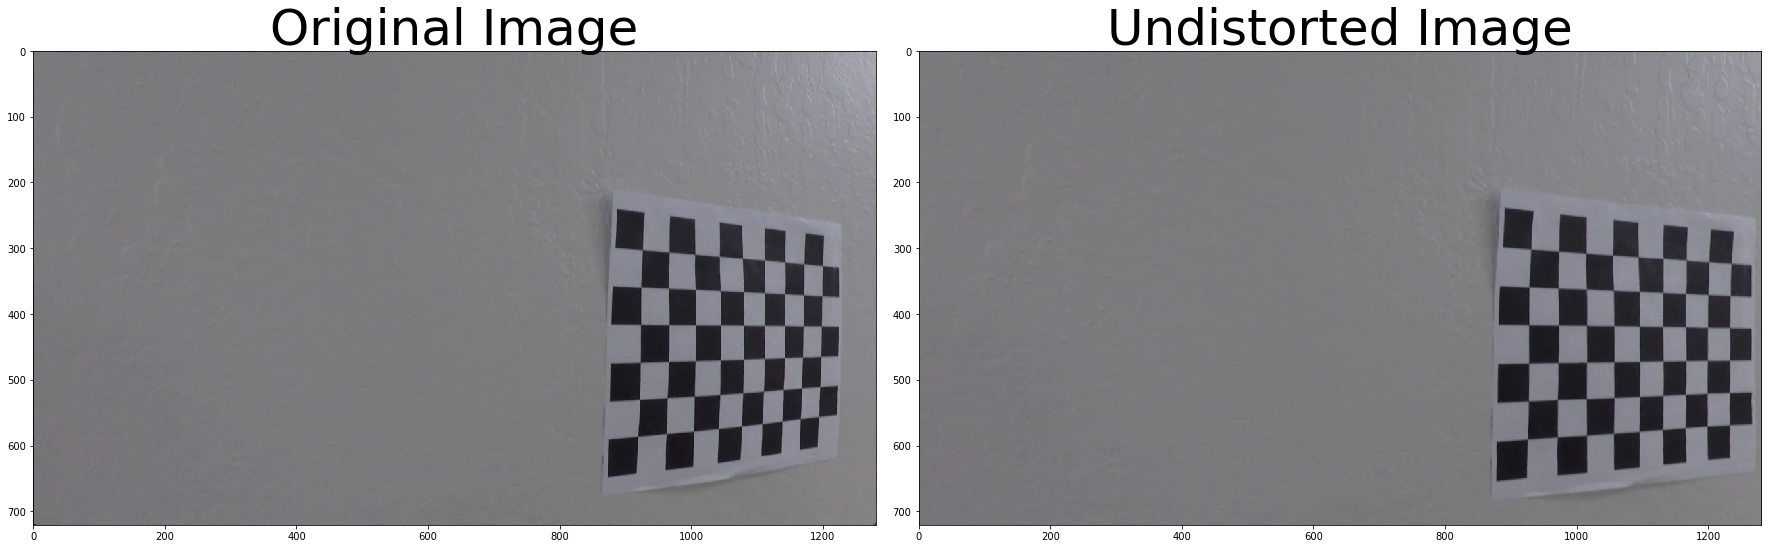

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    #reading in an image
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners - Currently no need for it
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

# Read one image to apply correction and check
test_img = mpimg.imread('./camera_cal/calibration15.jpg')
test_gray = cv2.cvtColor(test_img,cv2.COLOR_RGB2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test_gray.shape[::-1], None, None)#

# check the result on test_image
undist_img = cv2.undistort(test_img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
mpimg.imsave('test_images/original_image.jpg',test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_img)
mpimg.imsave('test_images/undistort_image.jpg',undist_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply a distortion correction to test image

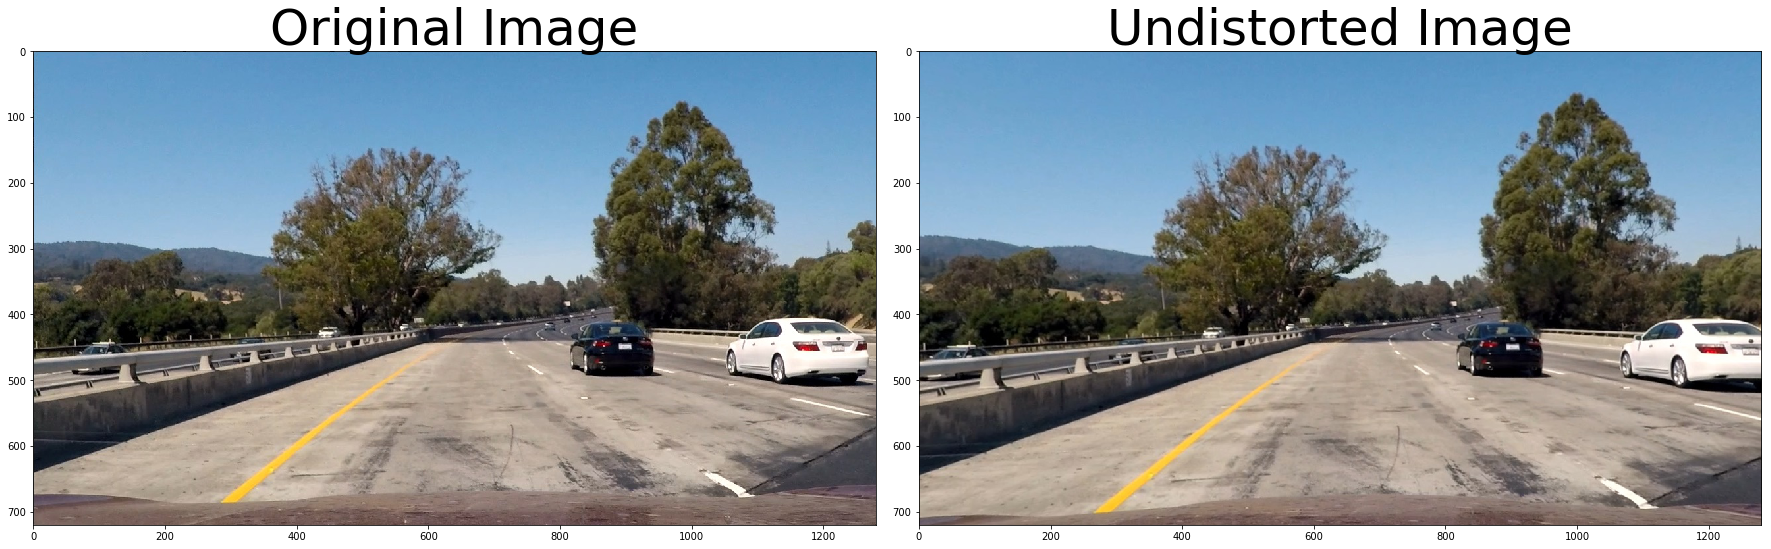

In [2]:
def distort_correct(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)
# Read one image to apply correction and check
rimg = mpimg.imread('./test_images/test1.jpg')
undist_rimg = distort_correct(rimg, mtx, dist)

# check the result on raw_image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(rimg)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_rimg)
ax2.set_title('Undistorted Image', fontsize=50)
mpimg.imsave('test_images/test1_undistorted.jpg',undist_rimg)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Use color transforms, gradients, etc., to create a thresholded binary image.


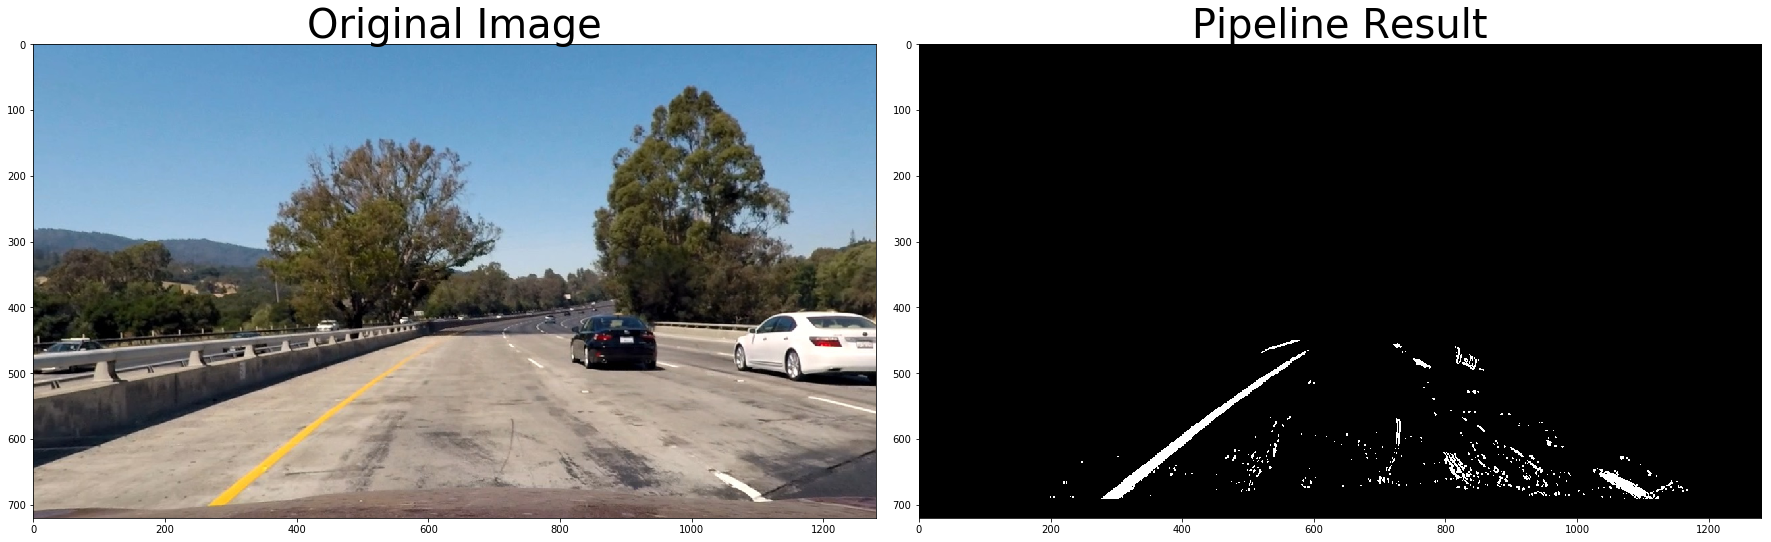

In [5]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # average slope and y intercept of right line
    m_avg_right = 0
    c_avg_right = 0
    # no of right lines
    n_right_line = 0
    
    # average slope and y intercept of left line
    m_avg_left = 0
    c_avg_left = 0
    # no of left lines
    n_left_line = 0
    #print(np.size(lines))
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = ((y2-y1)/(x2-x1))
            #print(m)
            c = y1-(m*x1)
            #for right line
            if (m > 0.4 and m < 0.7):
                m_avg_right = m_avg_right + m
                c_avg_right = c_avg_right + c
                n_right_line = n_right_line + 1
            #for left line
            if (m > -0.9 and m < -0.6):
                m_avg_left = m_avg_left + m
                c_avg_left = c_avg_left + c
                n_left_line = n_left_line + 1
    
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    #right line
    # initially just add all values and now taking average
    m_avg_right = m_avg_right/n_right_line
    c_avg_right = c_avg_right/n_right_line
    
    #Calculating Points
    y1 = img_height
    x1 = int((y1-c_avg_right)/m_avg_right)
    
    y2 = int(330)
    x2 = int((y2-c_avg_right)/m_avg_right)
    
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    
    #left line
    # initially just add all values and now taking average
    m_avg_left = m_avg_left/n_left_line
    c_avg_left = c_avg_left/n_left_line
    
    #Calculating Points
    y1 = img_height
    x1 = int((y1-c_avg_left)/m_avg_left)
    
    y2 = int(330)
    x2 = int((y2-c_avg_left)/m_avg_left)
    
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_old(line_img, lines)
    return line_img

def simple_thresh(img,thresh=(0, 255)):
    #apply only thresholding on image plane and return binary image
    binary = np.zeros_like(img)
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary

def combine_binary_and(bin1,bin2):
    #combine two binary image with '&' operation
    combined_binary = np.zeros_like(bin1)
    combined_binary[(bin1 == 1) & (bin2 == 1)] = 1
    return combined_binary

def combine_binary_or(bin1,bin2):
    #combine two binary image with '' operation
    combined_binary = np.zeros_like(bin1)
    combined_binary[(bin1 == 1) | (bin2 == 1)] = 1
    return combined_binary

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    #Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel_orient = cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    else:
        sobel_orient = cv2.Sobel(img, cv2.CV_64F, 0, 1,ksize=sobel_kernel)    
    #Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel_orient)
    #Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    #Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    #Return this mask as your binary_output image
    return sbinary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # Calculate the magnitude 
    abs_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # Return this mask as your binary_output image
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sdir = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(sdir)
    dir_binary[(sdir >= thresh[0]) & (sdir <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return dir_binary
    
# The main pipeline used for color transformation, finding gradient and applying thresholding
# h plane is quite sensitive and we have to select very narrow range and both yellow and white appear in that range.
# s plane we can play around in a bigger range while true color appear at higher values 140 seems good choice till now
# if changes require just tune from 140 to maximum 180, no other parameters
def pipeline(img, s_thresh=(140, 255), h_thresh=(15, 40), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # 2- Gaussian smoothing / blurring, video seems also not so sharp so kernel of size 3 would be sufficient
    kernel_size = 3
    l_channel = gaussian_blur(l_channel,kernel_size)
    
    # 3- Apply x-gradient with Sobel mask of size of 5 on L-plane and applying thresholding
    gradx_L = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=5, thresh=sx_thresh)
    mpimg.imsave('test_images/gradx_L.jpg',gradx_L,cmap='gray')
    
    # 4- Apply thresholding operation only on S and H channel
    s_binary = simple_thresh(s_channel,s_thresh)
    mpimg.imsave('test_images/s_binary.jpg',s_binary,cmap='gray')

    h_binary = simple_thresh(h_channel,h_thresh)
    mpimg.imsave('test_images/h_binary.jpg',h_binary,cmap='gray')

    
    # 4- combine S and H thresholded binary images 
    combined_sh = combine_binary_and(s_binary,h_binary)
    mpimg.imsave('test_images/combined_sh.jpg',combined_sh,cmap='gray')
    # 5- combine previous step thresholded image with tthresholded x-gradient image 
    combined_binary = combine_binary_or(combined_sh,gradx_L)
    mpimg.imsave('test_images/combined_binary.jpg',combined_binary,cmap='gray')

    # 6- Defining a four sided polygon to mask to final binary image
    imshape = combined_binary.shape
    vertices = np.array([[(150,imshape[0]-30),(550, 450), (800, 450), (imshape[1]-80,imshape[0]-30)]], dtype=np.int32)
    roi_edges = region_of_interest(np.uint8(combined_binary*255), vertices)
    mpimg.imsave('test_images/roi_edges.jpg',roi_edges,cmap='gray')
    
    # some convertion to return binary 3 dimention images
    roi_binary = np.zeros_like(roi_edges)
    roi_binary[roi_edges > 127] = 1
    
    # explore more options if the time permits
    #hough_binary = np.zeros_like(line_img[:,:,0])
    #hough_binary[line_img[:,:,0] > 127] = 1
    #final_binary = combine_binary_or(combined_binary,hough_binary)
    
    #kernel = np.ones((3,3),np.uint8)
    #dilation = cv2.dilate(roi_binary,kernel,iterations = 2)
    
    #kernel = np.ones((3,3),np.uint8)
    #erosion = cv2.erode(dilation,kernel,iterations = 3)
    
    #kernel = np.ones((3,3),np.uint8)
    #roi_binary = cv2.dilate(erosion,kernel,iterations = 1)
    return np.uint8(np.dstack(( roi_binary, roi_binary , roi_binary)) * 255)

# applying the pipeling for calclating the binary image
rimg_binary = pipeline(undist_rimg)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist_rimg)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(rimg_binary)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply a perspective transform to rectify binary image ("birds-eye view").

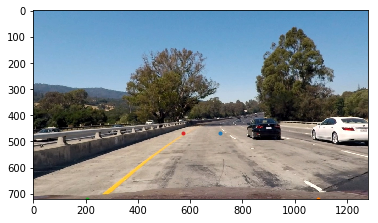

In [4]:
%matplotlib inline
plt.imshow(undist_rimg)
plt.plot(714,467,'.') #top right
plt.plot(1089,719,'.')  #bottom right
plt.plot(207,719,'.') #bottom left
plt.plot(572,467,'.') #top left


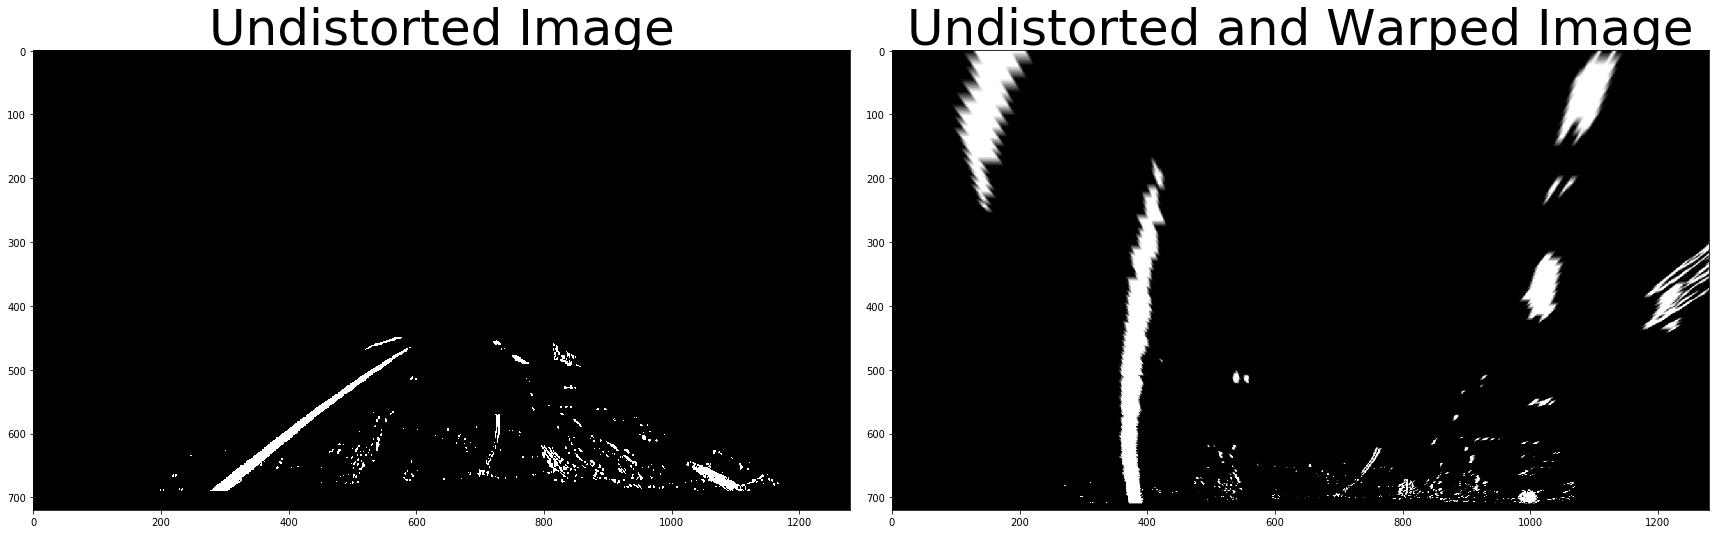

In [58]:
%matplotlib inline
# function to perform perspective transformation on input image based on the perspective transform matrix defined in M
def wrap_perspectTransform(img,M):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, img_size)
# source cornes selected trapizoidal shape
src_corners = []
src_corners.append([714,467]) #top right
src_corners.append([1089,719]) #bottom right
src_corners.append([207,719]) #bottom left
src_corners.append([572,467]) #top left

# destinal corners of a rectangel
dst_corners = []
dst_corners.append([950,220]) #top right
dst_corners.append([950,719]) #bottom right
dst_corners.append([350,719]) #bottom left
dst_corners.append([350,220]) #top left

src = np.float32(src_corners)
dst = np.float32(dst_corners)

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
# Warp the image using OpenCV warpPerspective()
warped = wrap_perspectTransform(rimg_binary, M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(rimg_binary)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
mpimg.imsave('test_images/warped.jpg',warped,cmap='gray')




## Detect lane pixels and fit to find the lane boundary.

(720, 0)

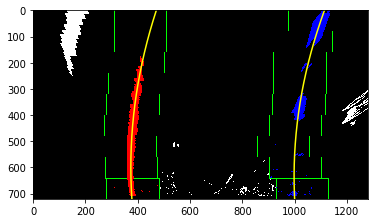

In [114]:
## Implement Sliding Windows and Fit a Polynomial
def slidingwindow_polyfit(binary,nwindows,margin,minpix):
    #binary_warped = warped[:,:,0]
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary[np.uint8(binary.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary, binary, binary))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    #nwindows = 9
    # Set height of windows
    window_height = np.int(binary.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    #margin = 100
    # Set minimum number of pixels found to recenter window
    #minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary.shape[0] - (window+1)*window_height
        win_y_high = binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]

    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    return left_fit, leftx, lefty, right_fit, rightx, righty, out_img

#just to make sure that this warping does not
binary_warped = np.zeros_like(warped[:,:,0])
binary_warped[warped[:,:,0] >= 128] = 1
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
left_fit, leftx, lefty, right_fit, rightx, righty, out_img = slidingwindow_polyfit(binary_warped,nwindows,margin,minpix)

## Visualization
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
mpimg.imsave('test_images/sliding_window.jpg',out_img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.savefig('myfig.jpg')

plt.xlim(0, 1280)
plt.ylim(720, 0)


In [68]:
## Look-Ahead Filter to search for line in a new frame within a window around the previous detection on last frames
def lookAhead_polyfit(binary,prev_left_fit, prev_right_fit, nwindows,margin,minpix):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #margin = 100
    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] - margin)) & (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] - margin)) & (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fit, leftx, lefty, right_fit, rightx, righty, out_img

## Finding the radius of curvature


In [69]:
# find curvature uses the same conversion from pixel to meters as discussed in the lecture
def find_curvature(binary,lefty,leftx,righty,rightx):
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    # Define conversions in x and y from pixels space to meters
    
    ploty = np.linspace(0, binary.shape[0]-1, binary_warped.shape[0] )
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.0/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)


    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

left_curverad, right_curverad = find_curvature(binary_warped,lefty,leftx,righty,rightx)
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m



518.692248711 m 489.916019312 m


## Create an image to draw the lines on


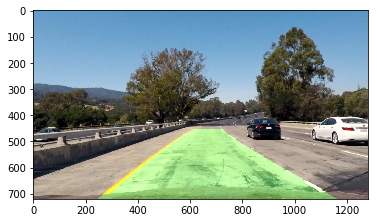

In [70]:
def plot_result(img,ploty,left_fitx,right_fitx,M):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = wrap_perspectTransform(color_warp,Minv)
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
result_img = plot_result(undist_rimg,ploty,left_fitx,right_fitx,M)
plt.imshow(result_img)
mpimg.imsave('test_images/Final_result.jpg',result_img)


In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients for the most recent n fits
        self.recent_fits = [] 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        #decision whether to append or use idx to put the new value
        self.append = True
        
        #current index in the arrays
        self.idx = 0
        
        #reset_counter
        self.rst_cnt = 0

In [111]:
# define a left and right objects of class Line
left_line = Line()
right_line = Line()
# no of iteration to consider for the final result calculation
N = 10 

# some global parameters
frame = 0

#Sanity Check
# For each new frame the decision whether to update the Left or Right lane measurements based on current frame 
# or take the same reading from the previous frames
# each line is taken if it's radius of curvature is within (1-rad_bound)*previous_rad and (1+rad_bound)*previous_rad
sanity_check_en = False
rad_bound = 0.3

# reset to take fresh measurements after 5 successive sanity check failed frames
reset = False
rst_rad_bound = 5 

# main code to process each frame
def process_frame(img_c):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    global frame, reset, sanity_check_en
    
    # apply distortion correction
    undist_rimg_c = distort_correct(img_c, mtx, dist)
    # calculate the binary thresholded image after going through the process defined in pipeline()
    rimg_binary_c = pipeline(undist_rimg_c)
    # Apply the perspective transformation and calulate the warped binary image
    warped_c = wrap_perspectTransform(rimg_binary_c, M)
    binary_warped_c = np.zeros_like(warped_c[:,:,0])
    binary_warped_c[warped_c[:,:,0] >= 128] = 1
    
    # for the very first frame and after reset apply slidingwindow_polyfit() to find lane lines otherwise apply lookAhead_polyfit() to search around a window around the previous detection.
    if (frame == 0) or reset:
        left_fit_c, leftx_c, lefty_c, right_fit_c, rightx_c, righty_c, out_img = slidingwindow_polyfit(binary_warped_c,nwindows,margin,minpix)
        reset = False
        #print(frame)
    else:
        #print(frame)
        left_fit_c, leftx_c, lefty_c, right_fit_c, rightx_c, righty_c, out_img = lookAhead_polyfit(binary_warped_c,left_line.current_fit[0], right_line.current_fit[0], nwindows,margin,minpix)
    
    
    
    #Find Angle of curvature for left and right line separately. Later it will be used in sanity check
    left_curverad, right_curverad = find_curvature(binary_warped_c,lefty_c,leftx_c,righty_c,rightx_c)
    ploty_c = np.linspace(0, img_c.shape[0]-1, img_c.shape[0] )
    left_fitx_c = left_fit_c[0]*ploty_c**2 + left_fit_c[1]*ploty_c + left_fit_c[2]
    right_fitx_c = right_fit_c[0]*ploty_c**2 + right_fit_c[1]*ploty_c + right_fit_c[2]
    
    #Find the position of vehicle with respect to center
    image_center = img_c.shape[1]/2
    lane_center = left_fitx_c[img_c.shape[0]-1] + (right_fitx_c[img_c.shape[0]-1] - left_fitx_c[img_c.shape[0]-1])/2
    temp_diff = image_center - lane_center
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.0/700 # meters per pixel in x dimension
    #apply pixel to meter conversion
    veh_pos = temp_diff*xm_per_pix
    
    if (sanity_check_en):
        # for left lane 
        # check the left lane found is almost straight, either parallel to right lane or equal to last frame left lane within some bound. 
        # We measure angle of curvature as a parameter to check. If check passed left lane is updated in left_line object
        if left_curverad > 1500 or right_curverad > 1500 or left_line.radius_of_curvature > 1500:
            left_line.detected = True
            left_line.rst_cnt = 0
        # check the left lane found is either parallel to right lane within some bound or equal to last frame left lane within some bound. We measure angle of curvature as a parameter to check
        # We measure angle of curvature as a parameter to check. If check passed left lane is updated in left_line object
        elif (left_curverad > (1-rad_bound)*left_line.radius_of_curvature and left_curverad < (1+rad_bound)*left_line.radius_of_curvature) or (left_curverad > (1-rad_bound)*right_curverad and left_curverad < (1+rad_bound)*right_curverad):
            left_line.detected = True
            left_line.rst_cnt = 0
        # Left lane failed the skip criteria so for this frame left_line object is not updated
        else:
            left_line.detected = False
            left_line.rst_cnt = left_line.rst_cnt+1
            if left_line.rst_cnt == rst_rad_bound:
                # Left lane detection failed for last consecutive value defined in rst_rad_bound, reset the whole flow to apply sliding window search for the next frame and remove previous frame history in left_line object
                reset = True
                left_line.rst_cnt = 0
        
        # for right lane 
        # check the right lane found is almost straight, either parallel to left lane or equal to last frame right lane within some bound. 
        # We measure angle of curvature as a parameter to check. If check passed right lane is updated in right_line object
        if right_curverad > 1500 or left_curverad > 1500 or right_line.radius_of_curvature > 1500:
            right_line.detected = True
            right_line.rst_cnt = 0
        # check the right lane found is either parallel to left lane within some bound or equal to last frame right lane within some bound.
        # We measure angle of curvature as a parameter to check. If check passed right lane is updated in right_line object
        elif (right_curverad > (1-rad_bound)*right_line.radius_of_curvature and right_curverad < (1+rad_bound)*right_line.radius_of_curvature) or (right_curverad > (1-rad_bound)*left_curverad and right_curverad < (1+rad_bound)*left_curverad):
            right_line.detected = True
            right_line.rst_cnt = 0
        # right lane failed the skip criteria so for this frame right_line object is not updated
        else:
            right_line.detected = False
            right_line.rst_cnt = right_line.rst_cnt+1
            if right_line.rst_cnt == rst_rad_bound:
                # right lane detection failed for last consecutive value defined in rst_rad_bound, reset the whole flow to apply sliding window search for the next frame and remove previous frame history in right_line object
                reset = True
                right_line.rst_cnt = 0
    else:
        left_line.detected = True
        right_line.detected = True
        sanity_check_en = True
    
    # if sanity check passed for left lane, update the left_line object
    if left_line.detected:
        if left_line.append:
            left_line.recent_xfitted.append(left_fitx_c)
            left_line.recent_fits.append(left_fit_c)
        else:
            left_line.recent_xfitted[left_line.idx] = left_fitx_c
            left_line.recent_fits[left_line.idx] = left_fit_c
        left_line.bestx = np.sum(left_line.recent_xfitted,axis=0)/np.shape(left_line.recent_xfitted)[0]
        left_line.current_fit[0] = left_fit_c
        left_line.best_fit = np.sum(left_line.recent_fits,axis=0)/np.shape(left_line.recent_fits)[0]
        left_line.radius_of_curvature = left_curverad
        
        left_line.idx = left_line.idx + 1
        if left_line.idx == N:
            left_line.append = False
            left_line.idx = 0
            
    # if sanity check passed for rigth lane, update the left_line object
    if right_line.detected:
        if right_line.append:
            right_line.recent_xfitted.append(right_fitx_c)
            right_line.recent_fits.append(right_fit_c)
        else:
            right_line.recent_xfitted[right_line.idx] = right_fitx_c
            right_line.recent_fits[right_line.idx] = right_fit_c
        right_line.bestx = np.sum(right_line.recent_xfitted,axis=0)/np.shape(right_line.recent_xfitted)[0]
        right_line.current_fit[0] = right_fit_c
        right_line.best_fit = np.sum(right_line.recent_fits,axis=0)/np.shape(right_line.recent_fits)[0]
        right_line.radius_of_curvature = right_curverad
        
        right_line.idx = right_line.idx + 1
        if right_line.idx == N:
            right_line.append = False
            right_line.idx = 0
    
    if reset: # flush the history only keep important things like curvature
        left_line.idx = 0
        right_line.idx = 0
        
        left_line.append = True
        right_line.append = True
        
        left_line.recent_xfitted = []
        right_line.recent_xfitted = []
        
        sanity_check_en = False
    
    result_c = plot_result(undist_rimg_c,ploty_c,left_line.bestx,right_line.bestx,M)
    
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
    cv2.putText(result_c,'Left Lane Curvature : %.2f m' % left_line.radius_of_curvature, (500,50), font, fontScale, fontColor, lineType)
    cv2.putText(result_c,'Right Lane Curvature : %.2f m' % right_line.radius_of_curvature, (500,100), font, fontScale, fontColor, lineType)
    if veh_pos < 0:
        cv2.putText(result_c,'Vehicle is %.2f m left of the center' % abs(veh_pos) , (500,150), font, fontScale, fontColor, lineType)
    else:
        cv2.putText(result_c,'Vehicle is %.2f m right of the center' % abs(veh_pos) , (500,150), font, fontScale, fontColor, lineType)

    
    #mpimg.imsave('project_video_output/frame'+str(frame)+'.jpg',result_c)
    frame = frame + 1
    return result_c

In [112]:
white_output = './project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("./project_video.mp4")

white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4



 24%|██▍       | 303/1261 [08:54<27:22,  1.71s/it]


 48%|████▊     | 605/1261 [17:55<17:59,  1.65s/it]


 72%|███████▏  | 907/1261 [26:44<10:21,  1.76s/it]


 96%|█████████▌| 1205/1261 [35:45<01:33,  1.68s/it]


100%|█████████▉| 1260/1261 [37:21<00:01,  1.75s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 

CPU times: user 34min 31s, sys: 2min 9s, total: 36min 40s
Wall time: 37min 23s


In [79]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))